<a href="https://colab.research.google.com/github/bboerschinger/colabs/blob/master/JAX_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import jax
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [3]:
## Only if you have a TPU runtime.
# Colab runtime set to TPU accel
import requests
import os
if 'TPU_DRIVER_MODE' not in globals():
  url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
  resp = requests.post(url)
  TPU_DRIVER_MODE = 1

# TPU driver as backend for JAX
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
print(config.FLAGS.jax_backend_target)

# Source: Cloud TPU NeurIPS 2019 Colab.

grpc://10.114.100.194:8470


In [4]:
# Helpers to keep tracks of names and parameters.
def create_name_scope():
  names = set()

  def make_name_fn(local_name):
    tmp_name = local_name
    i = 0
    while tmp_name in names:
      i += 1
      tmp_name = f'{local_name}:{i}'
    
    names.add(tmp_name)
    return tmp_name       

  return make_name_fn

def create_model():
  scope = create_name_scope()
  params = {}

  def add_layer_fn(layer_call_fn_layer_params):
    layer_call_fn, layer_params = layer_call_fn_layer_params
    params.update(layer_params)
    return layer_call_fn

  return params, scope, add_layer_fn

In [5]:
# Helper for random numbers.
def make_random_generator(seed):
  rng = jax.random.PRNGKey(seed=seed)

  def call_fn(num=1):
    nonlocal rng
    new_rngs = jax.random.split(key=rng, num=num+1)
    rng = new_rngs[0]
    if len(new_rngs[1:]) == 1:
      return new_rngs[1]
    else:
      return new_rngs[1:]

  return call_fn

rng_fn = make_random_generator(seed=0)

In [6]:
# Helpers when defining layers.
def make_local_getter(params, local_to_global):
  def get_fn(local_name):
    return params[local_to_global[local_name]]
  
  return get_fn


def make_local_setter(params, local_to_global, scope):
  def set_fn(local_name, value):
    local_to_global[local_name] = scope(local_name)
    params[local_to_global[local_name]] = value
  
  return set_fn

In [7]:
def sgd_update(params, gradients, learning_rate):
  return {
      k: v - learning_rate * gradients[k] for (k, v) in params.items()
  }

In [14]:
# Example layer - simple feed forward network.
def make_ffn(num_in, num_out, rng_fn, activation_fn, scope):
  _local_to_global = {}
  _params = {}

  add_weight = make_local_setter(params=_params, 
                                 local_to_global=_local_to_global,
                                 scope=scope)
  
  add_weight('W', jax.random.normal(key=rng_fn(), shape=(num_in, num_out)))
  add_weight('b', jax.random.normal(key=rng_fn(), shape=(num_out,)))

  def call_fn(inputs, params, rng, training):
    """
      inputs:  [batch_size, num_in]
    """
    get_weight = make_local_getter(params=params,
                                   local_to_global=_local_to_global)
    
    # [batch_size, num_out]
    activations = inputs @ get_weight('W') + get_weight('b')

    if activation_fn is not None:
      activations = activation_fn(activations)  

    return activations

  return (call_fn, _params)

def make_residual_layer(wrapped_layer):
  def call_fn(inputs, params, rng, training):
    return inputs + wrapped_layer(inputs, params, rng, training)

  return call_fn

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


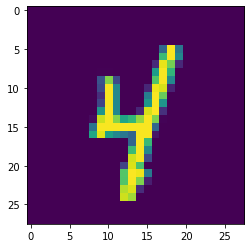

In [9]:
# Load mnist_data.
mnist_data = tfds.load('mnist')
train_data, test_data = mnist_data['train'], mnist_data['test']

image_spec = train_data.element_spec['image']
input_dimensionality = image_spec.shape[0] * image_spec.shape[1]

number_of_classes = 10

plt.imshow(next(iter(train_data))['image'].numpy().squeeze())

# Flatten the images and turn things into numpy arrays.
def mnist_adapter(mnist_data, batch_size):
  def data_fn():
    for batch in mnist_data.batch(batch_size):
      image, label = batch['image'].numpy(), batch['label'].numpy()
      image = jax.numpy.reshape(image, newshape=(-1, input_dimensionality))
      yield (image, label)
  
  return data_fn

train_data_fn = mnist_adapter(mnist_data=train_data, batch_size=512)
dev_data_fn = mnist_adapter(mnist_data=test_data, batch_size=1024)  

In [17]:
# Create a model.

model_params, model_scope, add_layer_fn = create_model()
rng_fn = make_random_generator(seed=0)

def make_sequential_model(layers):
  def model_fn(inputs, params, rng, training):
    for layer_fn in layers:
      inputs = layer_fn(inputs=inputs,
                        params=params,
                        rng=rng,
                        training=training)
    return inputs
  
  return model_fn

model_fn = jax.jit(make_sequential_model([
  add_layer_fn(make_ffn(num_in=input_dimensionality, 
                        num_out=128, 
                        rng_fn=rng_fn, 
                        activation_fn=jax.nn.sigmoid, 
                        scope=model_scope)),
  add_layer_fn(make_ffn(num_in=128, 
                        num_out=64, 
                        rng_fn=rng_fn, 
                        activation_fn=jax.nn.sigmoid, 
                        scope=model_scope)),
  add_layer_fn(make_ffn(num_in=64, 
                        num_out=32, 
                        rng_fn=rng_fn, 
                        activation_fn=jax.nn.sigmoid, 
                        scope=model_scope)),
  add_layer_fn(make_ffn(num_in=32,
                        num_out=10,
                        rng_fn=rng_fn, 
                        activation_fn=None, 
                        scope=model_scope)),
]))

# Define a loss function.
def make_cross_entropy_loss(model_fn): 
  def loss_fn(params, inputs, labels):
    # [batch_size, number_of_classes]
    logits = model_fn(params=params, inputs=inputs, rng=None, training=None)
    
    # [batch_size, number_of_classes]
    one_hot_labels = jax.nn.one_hot(x=labels,
                                    num_classes=number_of_classes)
    
    # [batch_size, number_of_classes]  
    log_probs = jax.nn.log_softmax(logits)

    log_loss = -log_probs * one_hot_labels

    return jax.numpy.mean(log_loss)

  return jax.jit(loss_fn)

# Define an eval function.
def make_accuracy_eval_fn(model_fn):
  def eval_fn(params, data_fn):
    num_examples = 0
    num_correct = 0
    for image, label in data_fn():
      num_examples += image.shape[0]
      logits = model_fn(params=params, inputs=image, rng=None, training=None)
      prediction = jax.numpy.argmax(logits, axis=-1)
      correct = prediction == label
      num_correct += jax.numpy.sum(correct)
    return num_correct / num_examples

  return eval_fn  

grad_loss_fn = jax.value_and_grad(fun=make_cross_entropy_loss(model_fn))
accuracy_eval_fn = make_accuracy_eval_fn(model_fn)


In [18]:
learning_rate = 1.0

for epoch in range(100):
  epoch_loss = 0.0
  batches = 0
  for (image, label) in train_data_fn():
    loss, grad = grad_loss_fn(model_params, inputs=image, labels=label)
    epoch_loss += loss
    batches += 1
    model_params = sgd_update(params=model_params,
                              gradients=grad,
                              learning_rate=learning_rate)
  train_acc = accuracy_eval_fn(params=model_params, data_fn=train_data_fn)
  dev_acc = accuracy_eval_fn(params=model_params, data_fn=dev_data_fn)

  print(f'Epoch: {epoch+1}, loss={epoch_loss/batches}, '
        f'train_accuracy={train_acc}, dev_accuracy={dev_acc}')


Epoch: 1, loss=0.27514180541038513, train_accuracy=0.2637333273887634, dev_accuracy=0.2678999900817871
Epoch: 2, loss=0.1955207735300064, train_accuracy=0.3716000020503998, dev_accuracy=0.3752000033855438
Epoch: 3, loss=0.17144577205181122, train_accuracy=0.4556833505630493, dev_accuracy=0.45889997482299805
Epoch: 4, loss=0.15276162326335907, train_accuracy=0.5204833149909973, dev_accuracy=0.5254999995231628
Epoch: 5, loss=0.13794825971126556, train_accuracy=0.5624666810035706, dev_accuracy=0.5740000009536743
Epoch: 6, loss=0.12646447122097015, train_accuracy=0.5969333648681641, dev_accuracy=0.6049999594688416
Epoch: 7, loss=0.1164180114865303, train_accuracy=0.6258833408355713, dev_accuracy=0.6301000118255615
Epoch: 8, loss=0.10877803713083267, train_accuracy=0.6506666541099548, dev_accuracy=0.6563000082969666
Epoch: 9, loss=0.1024353951215744, train_accuracy=0.6715999841690063, dev_accuracy=0.6733999848365784
Epoch: 10, loss=0.09736721962690353, train_accuracy=0.6860333681106567, dev